# Práctica 2

Ahora es tu turno de construir un detector de objetos.

## Ejercicio obligatorio (5 puntos)

A continuación se listan una serie de datasets que están disponibles en Kaggle o en otras fuentes. El ejercicio que tenéis que realizar obligatoriamente consiste en elegir uno de esos datasets (también podéis elegir otro que vosotros prefiráis) y construir un modelo siguiendo las instrucciones proporcionadas en el notebook de instrucciones. Deberás completar los ejercicios planteados en el informe de prácticas, ten en cuenta que en los ejercicios planteados puedes tener que realizar algún cambio en el código proporcionado.

- [Kangaroo dataset](https://github.com/experiencor/kangaroo). En caso de utilizar este dataset tienes que eliminar la anotación y la imagen 00090 ya que está corrupta.
- [Racoon dataset](https://github.com/datitran/raccoon_dataset).
- [Wheat detection](https://www.kaggle.com/c/global-wheat-detection/data).
- [Winegrape Detection Dataset](https://github.com/thsant/wgisd).

También puedes elegir cualquiera de los datasets disponibles en [50+ Object Detection Datasets from different industry domains](https://towardsai.net/p/computer-vision/50-object-detection-datasets-from-different-industry-domains) o utilizar un dataset de otra fuente. **Ojo.** Cuidado con el tamaño de los datasets, si contienen muchas imágenes el proceso de entrenamiento puede ser muy largo.

## Ejercicios opcionales

A continuación se listan una serie de ejercicios adicionales. Para que estos ejercicios sean tenidos en cuenta han de ser documentadas en el propio notebook, dando una explicación de lo que se está haciendo. Debes crear un nuevo notebook para cada uno de los ejercicios que realices, completar los ejercicios planteados en el informe y guardarlo en este repositorio de GitHub.



HuggingFace no solo permite entrenar modelos con la arquitectura de YOLO sino también con otras muchas.
- Cambiar por otro modelo (1.5 puntos)
- *Ensemble* (1 punto). Una vez entrenados varios modelos crea un ensemble de los mismos para realizar predicciones. Para eliminar aquellos bounding boxes que se superpongan en la predicción usa la técnica de [Non maximum suppression](https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/).

Crea un space de HugginFace con el modelo que has creado (1 punto).

Además de la librería de HuggingFace existen otras librerías para entrenar modelos con arquitecturas que no están incluidas en HuggingFace. Elige una de las siguientes librerías y entrena un modelo con ella (1.5 punto):
- [FCOS](https://github.com/xuannianz/keras-fcos)
- [FSAF](https://github.com/xuannianz/FSAF)
- [YOLO v8](https://learnopencv.com/ultralytics-yolov8/)
- [YOLO v11](https://docs.ultralytics.com/es/models/yolo11/)
- [RF-DETR](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb?ref=blog.roboflow.com)

También puedes elegir otra librería que busques por tu cuenta con algún algoritmo que no esté disponible en las librerías anteriores.


Al finalizar, recuerda guardar los cambios en GitHub utilizando la opción Archivo -> Guardar una copia en GitHub.

In [13]:
!pip install -q datasets evaluate albumentations torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.2 MB/s eta 0:00:00


In [14]:
!pip install transformers==4.57.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [15]:
import albumentations
from datasets import Dataset, DatasetDict
from pathlib import Path
import json
import numpy as np
import os
from PIL import Image, ImageDraw
import torch
from transformers import AutoImageProcessor
import xml.etree.ElementTree as ET

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!git clone https://github.com/datitran/raccoon_dataset.git

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [10]:
import os
import xml.etree.ElementTree as ET

annotations_dir = "/content/raccoon_dataset/annotations"

classes = set()

for file in os.listdir(annotations_dir):
    tree = ET.parse(os.path.join(annotations_dir, file))
    root = tree.getroot()
    for obj in root.iter("object"):
        classes.add(obj.find("name").text)

print(classes)

{'raccoon'}


In [11]:
# Crear un diccionario para mapear las clases de Pascal VOC a los IDs de COCO
class_mapping = {
    "raccoon": 0
}

def convert_voc_to_coco(voc_dir, coco_output_file):
    """
    Convierte anotaciones de Pascal VOC a formato COCO JSON.

    Args:
        voc_dir: Directorio raíz de las anotaciones en formato Pascal VOC.
        coco_output_file: Ruta del archivo de salida en formato COCO JSON.
    """

    # Estructura básica del archivo COCO JSON
    coco_format = {
        "info": {"description": "My COCO dataset"},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": []
    }


    # Crear un contador para los IDs de las imágenes y anotaciones
    image_id = 1
    annotation_id = 1

    # Iterar sobre las imágenes y sus anotaciones
    for image_file in os.listdir(os.path.join(voc_dir, "images")):
        image_id += 1
        image_path = os.path.join(voc_dir, "images", image_file)
        annotation_file = os.path.join(voc_dir, "annotations", image_file.replace(".jpg", ".xml"))

        # Obtener el ancho y alto de la imagen
        img = Image.open(image_path)
        width, height = img.size

        # Parsear el archivo XML
        tree = ET.parse(annotation_file)
        root = tree.getroot()

        # Crear la entrada para la imagen en el formato COCO
        coco_format["images"].append({
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": image_file
        })

        # Crear las entradas para las anotaciones en el formato COCO
        for obj in root.iter("object"):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            class_name = obj.find("name").text
            category_id = class_mapping[class_name]

            coco_format["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
                "area": (xmax - xmin) * (ymax - ymin),
                "iscrowd": 0
            })
            annotation_id += 1

    # Crear las entradas para las categorías en el formato COCO
    for class_name, category_id in class_mapping.items():
        coco_format["categories"].append({
            "id": category_id,
            "name": class_name
        })

    # Guardar el archivo JSON
    with open(coco_output_file, 'w') as f:
        json.dump(coco_format, f, indent=4)



In [17]:
# raccoon no separa train y test
voc_dir = "/content/raccoon_dataset"
coco_output_file = "raccoon_annotations.json"
convert_voc_to_coco(voc_dir, coco_output_file)

In [18]:
def load_coco_dataset(image_dir, annotation_file):
    """
    Carga un dataset en formato COCO desde archivos de imágenes y anotaciones.

    Args:
        image_dir: Directorio que contiene las imágenes.
        annotation_file: Ruta al archivo JSON de anotaciones COCO.

    Returns:
        Un objeto `Dataset` de Hugging Face con las imágenes y anotaciones.
    """

    images = []
    annotations = []

    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    for image_data in coco_data['images']:
        image_path = os.path.join(image_dir, image_data['file_name'])
        images.append({
            'image': Image.open(image_path),
            'image_id': image_data['id'],
            'width': image_data['width'],
            'height': image_data['height']
        })

    for annotation_data in coco_data['annotations']:
        annotations.append({
            'bbox': annotation_data['bbox'],
            'category_id': annotation_data['category_id'],
            'image_id': annotation_data['image_id'],
            'id': annotation_data['id'],
            'area': annotation_data['area']
        })

    # Agrupar las anotaciones por imagen
    image_annotations = {}
    for annotation in annotations:
        image_id = annotation['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(annotation)

    # Crear el dataset en formato Hugging Face
    data = []
    for image in images:
        image_id = image['image_id']
        if image_id in image_annotations:
            image['annotations'] = image_annotations[image_id]
        else:
            image['annotations'] = []  # Puede que algunas imágenes no tengan anotaciones

        data.append(image)

    return Dataset.from_list(data)

full_image_dir = "/content/raccoon_dataset/images"
full_annotation_file = "raccoon_annotations.json"
full_dataset = load_coco_dataset(full_image_dir, full_annotation_file)

split = full_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({'train': split['train'], 'test': split['test']})

In [19]:
print("Train:", len(dataset["train"]))
print("Test:", len(dataset["test"]))


Train: 160
Test: 40


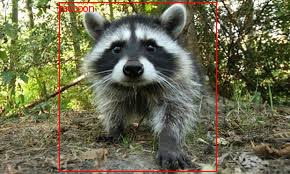

In [ ]:
id = 0
image = dataset["train"][id]["image"]
annotations = dataset["train"][id]["annotations"]
draw = ImageDraw.Draw(image)

id2label = {index: x for index, x in enumerate(class_mapping, start=0)}
label2id = {v: k for k, v in id2label.items()}

bboxes=[x['bbox'] for x in annotations]
category=[x['category_id'] for x in annotations]
area =[x['area'] for x in annotations]

for i in range(len(category)):
    box =bboxes[i-1]
    class_idx = category[i - 1]
    x, y, w, h = tuple(box)
    class_name= list(class_mapping.keys())[list(class_mapping.values()).index(class_idx)]
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), class_name, fill="red")

image

In [ ]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"]),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"]),
)

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
# transformar un batch
def transform_aug_ann_train(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["annotations"] ):
        image = np.array(image.convert("RGB"))[:, :, ::-1]

        out = train_augment_and_transform(image=image, bboxes=[x['bbox'] for x in objects], category=[x['category_id'] for x in objects], area =[x['area'] for x in objects])

        area.append(out["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

# transformar un batch
def transform_aug_ann_valid(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["annotations"] ):
        image = np.array(image.convert("RGB"))[:, :, ::-1]

        out = validation_transform(image=image, bboxes=[x['bbox'] for x in objects], category=[x['category_id'] for x in objects], area =[x['area'] for x in objects])

        area.append(out["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [ ]:
checkpoint = "hustvl/yolos-tiny"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
dataset["train"]=dataset["train"].with_transform(transform_aug_ann_train)
dataset["test"]=dataset["test"].with_transform(transform_aug_ann_valid)

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Ha habido que modificala para pasar de multiclase a clase única

import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from functools import partial
import torch

from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.
    """
    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format
    for batch in targets:
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Extraemos las métricas por clase
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")

    # CORRECCIÓN: Manejar el caso de una sola clase (tensor 0-d)
    if classes.ndim == 0:
        classes = [classes]
        map_per_class = [map_per_class]
        mar_100_per_class = [mar_100_per_class]

    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    # Convertir tensores a valores redondeados
    metrics = {k: round(v.item(), 4) for k, v in metrics.items() if isinstance(v, torch.Tensor)}

    return metrics

eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="yolo_finetuned_raccoon",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=4,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=True,
    report_to="none"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Raccoon,Mar 100 Raccoon
1,No log,1.698366,0.056100,0.153700,0.020100,-1.000000,0.000000,0.061000,0.207100,0.366700,0.557100,-1.000000,0.000000,0.600000,0.056100,0.557100
2,No log,1.403449,0.091700,0.233700,0.033900,-1.000000,0.015100,0.100400,0.228600,0.481000,0.628600,-1.000000,0.366700,0.648700,0.091700,0.628600
3,No log,1.531520,0.070500,0.201000,0.028800,-1.000000,0.003400,0.080500,0.238100,0.433300,0.583300,-1.000000,0.066700,0.623100,0.070500,0.583300
4,No log,1.603980,0.098700,0.265600,0.052500,-1.000000,0.006000,0.108100,0.235700,0.428600,0.561900,-1.000000,0.100000,0.597400,0.098700,0.561900
5,No log,1.681376,0.089300,0.234000,0.039700,-1.000000,0.004900,0.110400,0.204800,0.476200,0.561900,-1.000000,0.300000,0.582100,0.089300,0.561900
6,No log,1.651767,0.102800,0.262200,0.069100,-1.000000,0.007100,0.110500,0.276200,0.459500,0.576200,-1.000000,0.200000,0.605100,0.102800,0.576200
7,No log,1.060142,0.208500,0.391800,0.188900,-1.000000,0.015100,0.230000,0.421400,0.642900,0.733300,-1.000000,0.333300,0.764100,0.208500,0.733300
8,No log,0.996651,0.229500,0.404500,0.226600,-1.000000,0.041300,0.260000,0.452400,0.690500,0.759500,-1.000000,0.500000,0.779500,0.229500,0.759500
9,No log,0.857487,0.293000,0.496700,0.319400,-1.000000,0.146300,0.318200,0.554800,0.726200,0.783300,-1.000000,0.500000,0.805100,0.293000,0.783300
10,No log,0.875869,0.428400,0.701700,0.493800,-1.000000,0.114700,0.456500,0.573800,0.721400,0.776200,-1.000000,0.633300,0.787200,0.428400,0.776200


TrainOutput(global_step=1200, training_loss=0.7488488642374674, metrics={'train_runtime': 656.9029, 'train_samples_per_second': 7.307, 'train_steps_per_second': 1.827, 'total_flos': 2.6775498528822067e+17, 'train_loss': 0.7488488642374674, 'epoch': 30.0})

In [ ]:
trainer.push_to_hub()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...raccoon/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...raccoon/model.safetensors:  97%|#########6| 25.1MB / 25.9MB            

CommitInfo(commit_url='https://huggingface.co/adcelis/yolo_finetuned_raccoon/commit/0304e5aeb9a903236cf05d6610632253ebc7d12a', commit_message='End of training', commit_description='', oid='0304e5aeb9a903236cf05d6610632253ebc7d12a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/adcelis/yolo_finetuned_raccoon', endpoint='https://huggingface.co', repo_type='model', repo_id='adcelis/yolo_finetuned_raccoon'), pr_revision=None, pr_num=None)

In [5]:
import torch
import requests
import os

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

img_dir = "/content/raccoon_dataset/images"
img_name = sorted(os.listdir(img_dir))[0]
image = Image.open(os.path.join(img_dir, img_name)).convert("RGB")
print("Usando:", img_name)

Usando: raccoon-1.jpg


In [6]:
from accelerate.test_utils.testing import get_backend
device, _, _ = get_backend()
model_repo = "adcelis/yolo_finetuned_raccoon"

image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

The image processor of type `YolosImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/25.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [7]:
with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected raccoon with confidence 0.954 at location [68.89, 97.91, 534.19, 412.77]


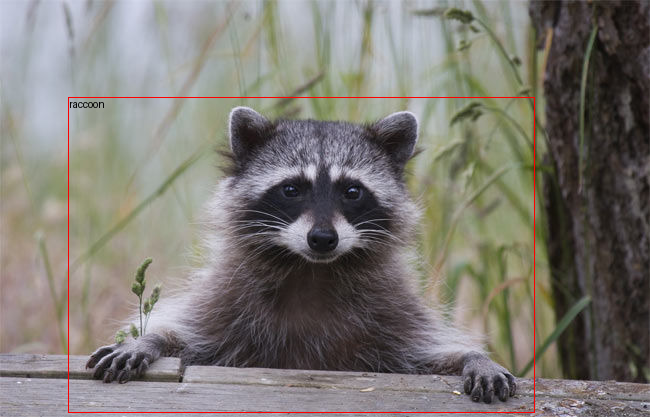

In [8]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="black")

image

# Ej Opcional 1

In [ ]:
checkpoint = "microsoft/conditional-detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
checkpoint = "SenseTime/deformable-detr"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)